In [18]:
import np as np
from math import*
import np as np
import pickle
import matplotlib.pyplot as plt
import control.matlab as cm


In [19]:
# Filename:  cit2s.m

# Calculation of state matrix and input matrix for calculation
# of symmetric aircraft response to atmospheric turbulence.
# The system model is in the form

#       .
#       x = Ax + Bu
#       -    -    -

# with
#     x = [u/V alpha theta qc/V u_g/V alpha_g alpha_g*]'
# and
#     u = [delta_e w_1 w_3]'.

# The turbulence filters are according to Dryden.

# Cessna Citation Ce-500, landing (1)

# Checked MM June 2021 - Python version by B. Englebert (July 2021)

# INPUT TURBULENCE- AND AIRCRAFT PARAMETERS




V = 189.6
m = 5445
twmuc = 2*147
KY2 = 0.950
c = 2.022
S = 24.2
lh = 5.5

xcg = 0.3 * c
W = 53361
b = 13.36
h = 6096
rho = 0.6528
mub = 22
muc = 157
KX2 = 0.013
KZ2 = 0.037
KXZ = 0.002

# TURBULENCE PARAMETERS
sigma = 2
Lg = 150
sigmaug_V = sigma/V
sigmaag = sigma/V

# AIRCRAFT SYMMETRIC AERODYNAMIC DERIVATIVES :
CX0 = 0.0000
CZ0 = -0.1620
Cm0 = 0.0000
CXu = -0.0600
CZu = -0.3240
Cmu = 0.0000
CXa = 0.0545
CZa = -5.8000
Cma = -0.5350
CXq = 0.0000
CZq = -4.3800
Cmq = -8.0000
CXd = 0.0000
CZd = -0.5798
Cmd = -1.4440
CXfa = 0.0000
CZfa = -1.8300
Cmfa = -4.7500
CZfug = 0.0000
Cmfug = -Cm0*lh/c
CZfag = CZfa-CZq
Cmfag = Cmfa-Cmq

# CALCULATION OF AIRCRAFT SYMMETRIC STABILITY DERIVATIVES
xu = (V/c)*(CXu/twmuc)
xa = (V/c)*(CXa/twmuc)
xt = (V/c)*(CZ0/twmuc)
xq = 0
xd = (V/c)*(CXd/twmuc)
xug = xu
xfug = 0
xag = xa
xfag = 0

zu = (V/c)*(CZu/(twmuc-CZfa))
za = (V/c)*(CZa/(twmuc-CZfa))
zt = (V/c)*(-CX0/(twmuc-CZfa))
zq = (V/c)*((CZq+twmuc)/(twmuc-CZfa))
zd = (V/c)*(CZd/(twmuc-CZfa))
zug = zu
zfug = (V/c)*(CZfug/(twmuc-CZfa))
zag = za
zfag = (V/c)*(CZfag/(twmuc-CZfa))

mu = (V/c)*((Cmu+CZu*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
ma = (V/c)*((Cma+CZa*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mt = (V/c)*((-CX0*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mq = (V/c)*(Cmq+Cmfa*(twmuc+CZq)/(twmuc-CZfa))/(twmuc*KY2)
md = (V/c)*((Cmd+CZd*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mug = mu
mfug = (V/c)*(Cmfug+CZfug*Cmfa/(twmuc-CZfa))/(twmuc*KY2)
mag = ma
mfag = (V/c)*(Cmfag+CZfag*Cmfa/(twmuc-CZfa))/(twmuc*KY2)

# STATE- AND INPUT MATRICES
A = np.mat([[xu, xa, xt, 0,    xug,                  xag,       0],
            [zu, za, zt, zq,   zug-zfug*V/Lg *
                (c/V),  zag,       zfag*(c/V)],
            [0,  0,  0,  V/c,  0,                    0,         0],
            [mu, ma, mt, mq,   mug-mfug*V/Lg *
                (c/V),  mag,       mfag*(c/V)],
            [0,  0,  0,  0,   -V/Lg,                 0,         0],
            [0,  0,  0,  0,    0,                    0,         1],
            [0,  0,  0,  0,    0,                   -(V/Lg)**2, -2*V/Lg]])

B = np.mat([[xd, 0,                                 0],
            [zd, zfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            zfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 0],
            [md, mfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            mfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  sigmaug_V*sqrt(2*V/Lg),            0],
            [0,  0,
                sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 (1-2*sqrt(3))*sigmaag*sqrt((V/Lg)**3)]])

C = np.eye(A.shape[0])
D = np.zeros(B.shape)


# # GAIN FACTORS FOR AUTOPILOT CHAPTER 7 AND DEFINITION OF MATRIX At
# # (approximately "Dead Beat" damping)
# Kt = -0.21
# Kq = -3      # gains on "theta" and "q"
# K = np.array([0, 0, Kt, Kq, 0, 0, 0])  # feedback matrix
# At = A-B[:, 0]*K         # new A matrix = (A - BK) because of feedback


1. Stability Analysis


In [20]:
Ar = np.delete(np.delete(A, [0, 2], axis=0), [0, 2], axis=1)
Br = np.delete(B, [0, 2], axis=0)
Cr = np.delete(np.delete(C, [0, 2], axis=0), [0, 2], axis=1)
Dr = np.delete(D, [0, 2], axis=0)


In [21]:
print(Ar.shape)
print(Br.shape)
print(Cr.shape)
print(Dr.shape)

(5, 5)
(5, 3)
(5, 5)
(5, 3)


In [22]:
sys = cm.ss(A, B, C, D)
sysr = cm.ss(Ar, Br, Cr, Dr)

In [23]:
# damping ratio and natural frequency
cm.damp(sys)
cm.damp(sysr)


_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6574      4.629
    -3.043    -3.488j     0.6574      4.629
 -0.009285  +0.06391j     0.1438    0.06458
 -0.009285  -0.06391j     0.1438    0.06458
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264
_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6573      4.629
    -3.043    -3.488j     0.6573      4.629
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264


(array([4.62884742, 4.62884742, 1.264     , 1.264     , 1.264     ]),
 array([0.65734029, 0.65734029, 1.        , 1.        , 1.        ]),
 array([-3.04272792+3.48827109j, -3.04272792-3.48827109j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]))

In [24]:
Kt = -0.21
Kq = -3      # gains on "theta" and "q"
K = np.array([0, 0, Kt, Kq, 0, 0, 0])  # feedback matrix
At = A-B[:, 0]*K         # new A matrix = (A - BK) because of feedback

syst = cm.ss(At, B, C, D)
Atr = np.delete(np.delete(At, [0, 2], axis=0), [0, 2], axis=1)
systr = cm.ss(Atr, Br, Cr, Dr)


In [25]:
cm.damp(syst)
cm.damp(systr)


_____Eigenvalue______ Damping___ Frequency_
    -3.479    +4.171j     0.6405      5.431
    -3.479    -4.171j     0.6405      5.431
  -0.02574                     1    0.02574
    -0.566                     1      0.566
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264
_____Eigenvalue______ Damping___ Frequency_
    -3.765    +3.134j     0.7686      4.899
    -3.765    -3.134j     0.7686      4.899
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264


(array([4.89907459, 4.89907459, 1.264     , 1.264     , 1.264     ]),
 array([0.76855828, 0.76855828, 1.        , 1.        , 1.        ]),
 array([-3.76522435+3.13432887j, -3.76522435-3.13432887j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]))

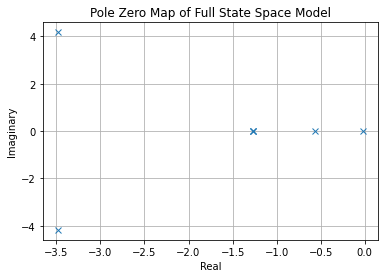

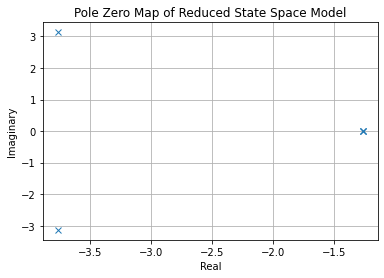

In [33]:

# elevator step response
# yout, T = cm.step(systr, T=np.linspace(0, 10, 2000),  input=0)

# # plot step response of 2nd state
# plt.figure(2)
# plt.plot(T, yout[:, 1] * 180 / np.pi)
# plt.title('Elevator Step Response')
# plt.xlabel('Time [s]')
# plt.ylabel('alpha [deg]')
# plt.grid()
# plt.show()

# plt.figure(3)
# plt.plot(T, yout[:, 3] * 180 / np.pi)
# plt.title('Elevator Step Response')
# plt.xlabel('Time [s]')
# plt.ylabel('qc/V [deg]')
# plt.grid()
# plt.show()

eigAt = np.linalg.eigvals(At)
eigAtr = np.linalg.eigvals(Atr)

# plot eigenvalues of A matrix
plt.figure(0)
plt.plot(np.real(eigAt), np.imag(eigAt), 'x')
plt.title('Pole Zero Map of Full State Space Model')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()
# plot eigenvalues of Ar matrix
plt.figure(1)
plt.plot(np.real(eigAtr), np.imag(eigAtr), 'x')
plt.title('Pole Zero Map of Reduced State Space Model')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid()
plt.show()


2. Time-Domain Analysis

In [34]:
sys = cm.ss(At, B, C, D)
sysr = cm.ss(Atr, Br, Cr, Dr)

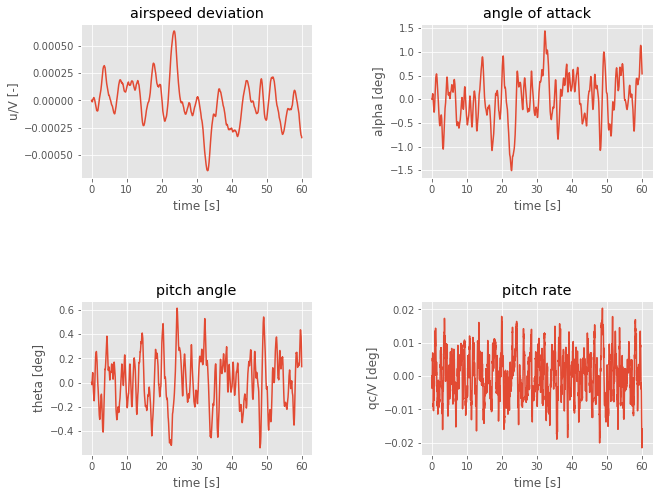

In [51]:

# TIME AXIS INPUT VECTOR DEFINITION
dt = 0.01
T = 60
t = np.arange(0, T + dt, dt)
N = len(t)

# N rows and 1 column
# randn is normal distribution
# INPUT VECTOR DEFINITION
nn = np.zeros((N, 1))                    # zero input elevator
w1 = np.random.randn(N, 1)/sqrt(dt)      # scaled input hor. turbulence,
# note the sqrt(dt) because of lsim
w3 = np.random.randn(N, 1)/sqrt(dt)      # scaled input vert. turbulence,
# note the sqrt(dt) because of lsim
u = np.hstack((nn, nn, w3))             # input vector definition (vertical
# turbulence only, can be changed).
y = cm.lsim(sys, u, t)[0]


# 2x2 plot for t vs y[:, 0] and t vs y[:, 1], etc.
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(t, y[:, 0])
plt.xlabel('time [s]')
plt.ylabel('u/V [-]')
plt.title('airspeed deviation')

plt.subplot(2, 2, 2)
plt.plot(t, y[:, 1]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('alpha [deg]')
plt.title('angle of attack')

plt.subplot(2, 2, 3)
plt.plot(t, y[:, 2]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('theta [deg]')
plt.title('pitch angle')

plt.subplot(2, 2, 4)
plt.plot(t, y[:, 3]*180/pi)
plt.xlabel('time [s]')
plt.ylabel('qc/V [deg]')
plt.title('pitch rate')
# space out the plots
plt.tight_layout()
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# make the plots more fancy
plt.style.use('ggplot')
plt.savefig('figures/states_vs_t.pdf')
plt.show()


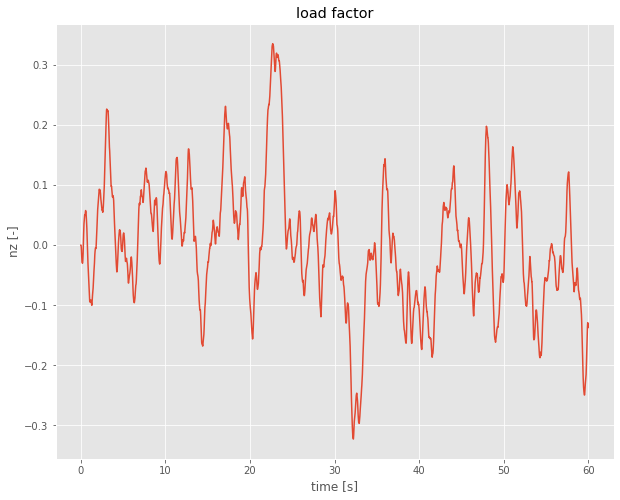

In [55]:
az = V * (y[:, 2] - y[:, 1])  # V * flight path angle dot
nz = az / 9.81                   # normal load factor

# plot nz vs t
plt.figure()
plt.plot(t, nz)
plt.xlabel('time [s]')
plt.ylabel('nz [-]')
plt.title('load factor')
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
plt.savefig('figures/nz_vs_t.pdf')